# Exploration of Clutch Factor
## CS109a Final Project
** Tommy, Kyle, Toni, Chip ** 12/07/16

In [21]:
## Load necessary libraries
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

** Description of work within: **

- Load in dataset with proper features
    - Generate clutch variable
    - Encode other variables as needed

- Implement baseline model: logit reg of indicator for making shot on clutch metric
    - Run this regression for whole dataset
    - Graph logistic function y versus x


- Improve baseline model by adding confounding variables
    - Compare p-values of predictors
    - Interpret Coefficients    
    
- Implement robust model for specific players
    - Import top 20 players from previous work
    - Top 20 players selected by generating a score that balances high shot variance and number of shots per game. We want to look at frequent shooters from all over the floor, not just big men or 3-point specialists

In [41]:
## Load in dataset with proper features

# Read in data
data = pd.read_csv('datasets/Augmented_Dataset.csv', index_col=0)
data.columns = map(str.lower, data.columns)

# Generate previous_streak variable
data['previous_streak'] = data.groupby(['player_id', 'game_id'])['current_streak'].apply(lambda x: x.shift(1).fillna(0)).astype(int)

# Preview data
print 'Number of variables:', np.shape(data)[1]
print 'Variable names:', data.columns.values
print 'Number of observations/shots:', np.shape(data)[0]
data.head(10)

Number of variables: 24
Variable names: ['game_id' 'matchup' 'location' 'w' 'final_margin' 'shot_number' 'period'
 'game_clock' 'shot_clock' 'dribbles' 'touch_time' 'shot_dist' 'pts_type'
 'shot_result' 'closest_defender' 'closest_defender_player_id'
 'close_def_dist' 'fgm' 'pts' 'player_name' 'player_id' 'fg_percent'
 'current_streak' 'previous_streak']
Number of observations/shots: 118033


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,fg_percent,current_streak,previous_streak
28621,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,1,1,2:29,22.1,0,...,"Roberts, Brian",203148,4.4,1,3,ryan anderson,201583,0.407407,1,0
28622,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,2,2,11:19,5.8,2,...,"Zeller, Cody",203469,6.1,1,2,ryan anderson,201583,0.407407,2,1
28623,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,3,2,10:51,10.2,2,...,"Maxiell, Jason",101131,5.7,0,0,ryan anderson,201583,0.407407,-1,2
28624,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,4,2,8:21,24.0,0,...,"Zeller, Cody",203469,2.6,1,2,ryan anderson,201583,0.407407,1,-1
28625,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,5,2,7:59,16.0,0,...,"Zeller, Cody",203469,6.5,0,0,ryan anderson,201583,0.407407,-1,1
28626,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,6,2,6:59,22.0,0,...,"Williams, Marvin",101107,8.7,1,3,ryan anderson,201583,0.407407,1,-1
28627,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,7,3,0:03,NaN,0,...,"Zeller, Cody",203469,3.1,0,0,ryan anderson,201583,0.407407,-1,1
28628,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,8,4,11:30,10.1,0,...,"Zeller, Cody",203469,6.1,0,0,ryan anderson,201583,0.407407,-2,-1
28629,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,9,4,10:56,10.2,1,...,"Zeller, Cody",203469,1.8,1,2,ryan anderson,201583,0.407407,1,-2
28630,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,10,4,8:23,9.1,2,...,"Zeller, Cody",203469,6.6,1,2,ryan anderson,201583,0.407407,2,1


In [42]:
## Data manipulation/cleaning

# Convert categorical variable into dummy/indicator variables
encoding = pd.get_dummies(data['w'])
data = pd.concat((data, encoding), axis=1)
data.drop('L', axis=1, inplace=True)

# convert all game_clock values from strings in ints of seconds remaining
# grab old clock data
old_clock = data['game_clock'].values
new_time = []

# loop through and make new_time array
for x in old_clock:
    minutes, seconds = x.split(':')
    minutes, seconds = float(minutes), float(seconds)
    new_time.append(minutes*60 + seconds)
    
# create new predictor column
data['game_clock'] = new_time

In [43]:
# fill missing 'shot_clock' vals
for index, row in data.iterrows():
    if pd.isnull(row['shot_clock']):
        # Impute missing 'shot_clock' val as the game_clock value, since the shot clock was turned off in this case
        data.set_value(index, 'shot_clock', row['game_clock'])

## Defining 'Clutch_Score'

We want to create a 'clutch_score' variable that measures the degree of how clutch a given shot is. Clutch can be defined as such: During a critical moment of the game, how much will this shot improve the chances of my team winning?

In our given dataset, there are a few variables we believe define a clutch shot. These include 
- **'game_clock'**: How much time is left in the game? In this closing seconds of a game, a made shot would be more clutch. We'll define clutch time as any point in the game with < 5 minutes (300s) remaining in the 4th quarter, which is the same way the NBA defines it. 

- **'pts_type'**: What type of shot was taken? A 3-point shot would be more clutch than a 2-pointer since it affects your team's score more. 

- **'final_margin'**: What was the ending score of the game? Shots made in a close game are more clutch than in a game that has one team with a big lead. Ideally, we would've liked to use the margin of the score at the time of the game, but our dataset does not provide that information, so we are using final_margin instead. We'll use the absolute value of final_margin, and define shots with a final_margin > 6 as not clutch, since that is greater than a 2 possession game. 

We can combine these three variables to create a 'clutch_score' that measures the degree of how clutch the shot is. We are choosing to define clutch_score as such:

$$
Clutch Score = \frac{Pts Type}{\frac{Game Clock}{300 seconds} * Final Margin}
$$

This gives us a dimensionless parameter, and ensures that each parameter is given equal weight. A larger number translates to a more clutch shot. For all shots not taken in the 4th quarter with less than 5 minutes left, clutch_score = 0. Also, for all shots taken in a game with a final_margin > 6, clutch_score = 0. 

In [44]:
# calculate the clutch variable for each shot

# create array to hold clutch variable
clutch_score = []

for index, row in data.iterrows():
    if (row['period'] == 4 and row['game_clock'] < 300) and (abs(row['final_margin']) <= 6):
        normalized_game_clock = row['game_clock'] / 300
        # some shots taken at 0:00, but we can't divide by 0, so we'll say the game_clock was at .1s
        if normalized_game_clock == 0:
            normalized_game_clock = .1 / 300
        clutch_calc = row['pts_type'] / (normalized_game_clock * abs(row['final_margin']))
        clutch_score.append(clutch_calc)
    else:
        clutch_score.append(0)
        
data['clutch_score'] = clutch_score

print 'Number of shots: {0}'.format(np.shape(data)[0])
print 'Number of clutch shots: {0}'.format(len(data[data['clutch_score'] > 0]))

Number of shots: 118033
Number of clutch shots: 4653


In [45]:
## Implement baseline model: logit reg of indicator for making shot on clutch metric
    # Run this regression for top 20 players
    # Assess model's quality
    
# Split x and y
x = data['clutch_score']
x = x.reshape(-1, 1)
y = data['fgm'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
baseline_logit = LogisticRegression()
baseline_logit.fit(x_train, y_train)

# Print coefficients
coef = baseline_logit.coef_[0][0]
print 'Coefficient on clutch predictor:', coef

# Score model
score = baseline_logit.score(x_test, y_test)
print 'Classification rate:', score

Coefficient on clutch predictor: -0.000221882066459
Classification rate: 0.546130385055


** Discussion: **

Even without any other predictors the coefficient on the clutch predictor is a pretty precisely estimated 0. Furthermore, the model barely performs any better than 50% i.e. the model is not much better than flipping a coin, so in this situation the clutch theory looks weak from a league-wide perspective.

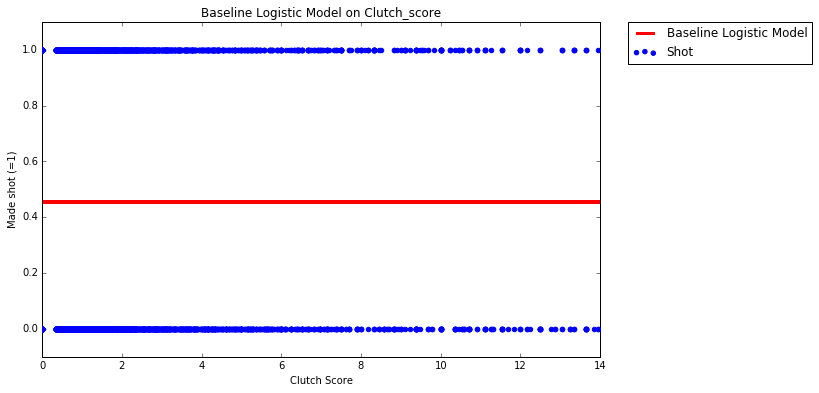

In [70]:
## Graph y as a function of x

# Fit model
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Plot the result
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.scatter(x.ravel(), y, color='b', zorder=20)
def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(x_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(x_test, loss, color='red', linewidth=3)

plt.ylabel('Made shot (=1)')
plt.xlabel('Clutch Score')
plt.ylim(-0.1, 1.1)
plt.xlim(0, 14)
plt.legend(('Baseline Logistic Model', 'Shot'),
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Baseline Logistic Model on Clutch_score')
plt.show()

Even the graph of the model shows a pretty useless and nondescriminant model, and it appears to be an almost horizontal line.

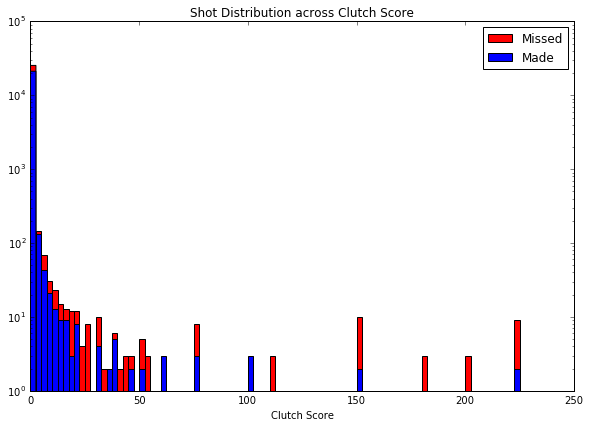

In [69]:
## Add distributions of previous_streak variable dependent on whether shot was made or not
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)

ax1.hist(x_test[y_test==0], bins=100, range=(0, 250), color='red', alpha=1, label='Missed', log=True)
ax1.hist(x_test[y_test==1], bins=100, range=(0, 250), color='blue', alpha=1, label='Made', log=True)
plt.legend(loc='upper right')
plt.xlabel('Clutch Score')
plt.title('Shot Distribution across Clutch Score')
plt.tight_layout()
plt.show()

In [29]:
## Using statsmodels

# Fit the model
logit = sm.Logit(data['fgm'], data['clutch_score'])
result = logit.fit()

# Print results
result.summary()

Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    fgm   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118032
Method:                           MLE   Df Model:                            0
Date:                Mon, 12 Dec 2016   Pseudo R-squ.:               -0.005936
Time:                        20:04:29   Log-Likelihood:                -81810.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                       nan
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
clutch_score    -0.0002   9.94e-05     -2.444      0.015        -0.000 -4.81e-05
================================================================================
"""

We see here that p-value for our clutch_score coefficient is < .05, so it is significant. This tells us that by itself, clutch_score is a poor predictor of a made shot. This is expected since we aren't accounting for difficulty of the shot. 

In [30]:
## Checking for confounding variables
    # One by one, add in what you believe could be confounding variables 
    # and see if the ‘clutch_score’ metric turns/still is significant.

# Create array of possible confounders
possible_confounders = ['clutch_score', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist', 
                        'fg_percent', 'shot_clock']

# Choose x_set
x = data[possible_confounders]
y = data['fgm'].values

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.661951
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118026
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2016   Pseudo R-squ.:                 0.03929
Time:                        20:04:29   Log-Likelihood:                -78132.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
clutch_score   -6.639e-05   9.12e-05     -0.728      0.467        -0.000     0.000
dribbles           0.0340      0.005      7.283      0.000         0.025     0.043
touch_time        -0.0685      0.005    -12.625      0.000        -0.079    -0.058
shot_dist         -0.0616      0.001    -74.480      0.000        -0.063    -0.060
close_def_dist     0.1062      0.003     37.563      0.000         0.101     0.112
fg_percent         0.7351      0.030     24.183      0.000         0.676     0.795
shot_clock         0.0001      0.000      1.175      0.240     -9.15e-05     0.000
==================================================================================
"""

In [31]:
## Score model

# Split robust predictors
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
robust_logit = LogisticRegression(C=100000000.0)
robust_logit.fit(x_train, y_train)

# Score and print
score = robust_logit.score(x_test, y_test)
print 'Classification rate:', score

Classification rate: 0.605265387385


When we incorporate other variables, we see that the clutch_score coefficient goes further to 0, although its p-value shows this isn't a significant estimate. Other variables have larger coefficient with significance, and we see that fg_percent is actually the best indicator for these shots. 

In [32]:
## Interpreting coefficient

print 'Coefficient odds ratio and 95% CI:'
print ''
params = result.params
conf = result.conf_int()
conf['Estimated coefficient'] = params
conf.columns = ['2.5%', '97.5%', 'Estimated coefficient']
print np.exp(conf)


Coefficient odds ratio and 95% CI:

                    2.5%     97.5%  Estimated coefficient
clutch_score    0.999755  1.000112               0.999934
dribbles        1.025174  1.044116               1.034602
touch_time      0.923895  0.943761               0.933775
shot_dist       0.938728  0.941776               0.940251
close_def_dist  1.105931  1.118259               1.112078
fg_percent      1.965109  2.213798               2.085750
shot_clock      0.999909  1.000365               1.000137


** Interpreting coefficients **

The above shows us that the exponential of the produced coefficients from the logistic regression. This tells us how a 1 unit increase in a variable affects the odds of making the shot.

So for the above, an increase in one's clutch_score by 1 unit, actually decreases the odds of making the next shot by less than .01 percent. This is *such* a small effect. It is, again, actually impressive how small of an effect this is.

### Extending Analysis to Players

It is not surprising that the clutch factor doesn't appear to exist across the league according to our above analysis. The theory is that there are certain players that are clutch, not that everyone is more clutch. Thus, it is important to extend our analysis to individual players to see if there are individually clutch players. We'll do that below.

In [33]:
## Define function which takes as input player_name, runs logit model on them,
    # prints coef on clutch_score, std err, p-val, and r^2
    
def player_clutch_logit(player_name):
    
    # Get player data
    player_data = data[data['player_name']==player_name]
    
    # get number of clutch shots this player took for an idea of sample size
    num_clutch_shots = len(player_data[player_data['clutch_score'] != 0])
    
    # Set x and y
    y = player_data['fgm'].values
    x = player_data[possible_confounders]

    # Fit model
    logit = sm.Logit(y, x)
    result = logit.fit(disp=0)
    
    coeff = result.params.clutch_score
    p_value = result.pvalues.clutch_score
    r_squared = result.prsquared
    return coeff, p_value, r_squared, num_clutch_shots

In [34]:
## Players of note
players_sorted = pd.read_csv('datasets/df_score.csv')
key_players = players_sorted.iloc[:,0].values[:50]

In [35]:
# run complex model
# create arrays to hold coeff, p_value, and r_squared
player_coeff_array = []
player_pvalue_array = []
player_rsquared_array = []
player_clutchshots_array = []

# Loop through players
for player in key_players:
    
    # Run function
    coeff, p_value, r_squared, num_clutch_shots = player_clutch_logit(player)
    
    # store values
    player_coeff_array.append(coeff)
    player_pvalue_array.append(p_value)
    player_rsquared_array.append(r_squared)
    player_clutchshots_array.append(num_clutch_shots)

In [36]:
# now create table with player, coefficient, p-value, and R^2 value
top_player_info = pd.DataFrame({'Player Name': key_players})
top_player_info['Clutch Score Coefficient'] = player_coeff_array
top_player_info['p-Value'] = player_pvalue_array
top_player_info['Number of Clutch Shots Taken'] = player_clutchshots_array
top_player_info['Pseudo R^2'] = player_rsquared_array
# top_player_info.sort_values('p-Value', inplace=True)
top_player_info.head(50)

,Player Name,Clutch Score Coefficient,p-Value,Number of Clutch Shots Taken,Pseudo R^2
0,lebron james,-0.000381,0.988066,38,0.083728
1,damian lillard,-0.033214,0.162169,70,0.054671
2,russell westbrook,-0.048840,0.279064,57,0.050124
3,james harden,0.000221,0.862742,52,0.036805
4,carmelo anthony,-0.001489,0.608628,53,0.039329
5,stephen curry,0.012722,0.426150,39,0.047465
6,kobe bryant,-0.003112,0.582586,65,0.040115
7,derrick rose,-0.028397,0.321654,41,0.039835
8,kyrie irving,-0.002757,0.915803,41,0.019428
9,kemba walker,-0.000321,0.674168,62,0.030736


**Note:** As we evaluate the model on a large number of players, we have to keep in mind the issue of Multiple Comparisons. This idea says that as we're comparing p-values across a large number of independent samples, there is a high chance of at least one having a p-value < 0.05 due to a probability distribution alone, and not necessarily due to significance. We have to adjust what our p-value cutoff for significance is. In this case, Multiple Comparisons across 50 samples says our proper p-value will be:


$$
NewPValue = 1-0.95^{1/50} = 0.00103
$$


In [37]:
# split into clutch players vs. choke artists (opposite of clutch)
clutch_players = top_player_info[top_player_info['Clutch Score Coefficient'] > 0]
clutch_players.sort_values('Clutch Score Coefficient', ascending=False, inplace=True)
clutch_players.head(10)

C:\Users\Toni\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Player Name,Clutch Score Coefficient,p-Value,Number of Clutch Shots Taken,Pseudo R^2
37,anthony davis,1.477263,0.027092,28,0.096985
31,goran dragic,0.162974,0.136920,26,0.094654
13,lamarcus aldridge,0.023726,0.607758,59,0.041493
30,mike conley,0.014608,0.129422,61,0.032945
18,brandon knight,0.013572,0.399512,65,0.032230
5,stephen curry,0.012722,0.426150,39,0.047465
42,dwayne wade,0.003701,0.310978,45,0.060043
17,victor oladipo,0.002905,0.919211,31,0.069084
29,demarcus cousins,0.001742,0.547228,30,0.044178
47,mario chalmers,0.000881,0.910272,18,0.041150


**Clutch Player Analysis:**

When we look at the players with positive clutch_score coefficients in descending order, we can examine which players are the most clutch according to our model. We see that most of these player models have a p-value > .05, so we can't say that these clutch score coefficients are significant results, though there are some that are quite close. However, when we examine by our Multiple Comparisons adjusted criteria with p = .00103, we see that none of our players actually have a significant result.

In regards to the the lack of significance of our results, we see that based on 'Number of Clutch Shots Taken', we are working with quite small sample sizes for our data and therefore it is difficult for our model to draw strong conclusions. If we were working with more data, we could further explore some other potentially clutch players for who we don't currently have enough data for. 

With these findings, our model implementation suggests that there is no support for Clutch Factor.

In [74]:
choke_players = top_player_info[top_player_info['Clutch Score Coefficient'] < 0]
choke_players.sort_values('Clutch Score Coefficient', inplace=True)
choke_players.head(10)

C:\Users\Toni\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Player Name,Clutch Score Coefficient,p-Value,Number of Clutch Shots Taken,Pseudo R^2
16,ryan anderson,-0.547940,0.184407,15,0.035548
21,wilson chandler,-0.236624,0.208822,26,0.055615
28,rudy gay,-0.160128,0.106130,32,0.046879
20,jimmy butler,-0.151711,0.083607,32,0.061037
24,kevin love,-0.068036,0.439486,22,0.040107
35,paul millsap,-0.060293,0.616111,35,0.065346
44,darren collison,-0.051264,0.528294,27,0.045969
2,russell westbrook,-0.048840,0.279064,57,0.050124
43,dj augustin,-0.045646,0.671522,19,0.042967
34,john wall,-0.045104,0.310213,39,0.055942


**Choke Artist Analysis:**

Looking at players with negative clutch score coefficients sorted by p-value, we  see that no p-values are < .00103 or even < .05, and therefore we can't determine our results to be significant. Thus for our data and model, we can't declare any player to definitely be a choke artist. Thus we don't find any support for non-clutch players, and it appears that with our model there is no significance for clutchness being a factor in shot probability.


# Overall Thoughts

This analysis of Clutch Factor presents results that, based on our data and implementation of a clutch score, don't support the idea of players being clutch towards the ends of games. With more variables and shot data available, we could try to find stronger support for our findings and potentially find that there may be some players who could be called clutch. Like discussed before, a flaw of our data is that we don't have a variable for the game score at the time of the shot, but only the final margin, so we can't fully measure just how close a game is in a given instance. This information would provide better measurements of our 'Clutch Score' and may help further inform our model. Further study should also be done by varying the definition of Clutch Score, as there may be a more accurate way to define how clutch a given shot is. For our definition of Clutch Score, we didn't find any support for the clutch theory, but other definitions of Clutch Score may provide different results.

For our analysis of the data, we can conclude that the Clutch Factor is just another fallacy. 